  Author: Ankit Kariryaa, University of Bremen
  
  Modified by Xuehui Pi and Qiuqi Luo



In [1]:
from tensorflow.keras.models import load_model
import numpy as np               # numerical array manipulation
import pandas as pd
import geopandas as gps
import os
import time
from collections import defaultdict
from functools import reduce
from PIL import Image
import rasterio                  # I/O raster data (netcdf, height, geotiff, ...)
import rasterio.warp             # Reproject raster samples
from shapely.geometry import Point, Polygon
from shapely.geometry import mapping, shape
import fiona
import cv2
from tqdm import tqdm
import rasterio.mask
import affine

from core.UNet import UNet
from core.losses import tversky, accuracy, dice_coef, dice_loss, recall,precision,IoU
from core.optimizers import adaDelta, adagrad, adam, nadam
from core.frame_info_evaluate import FrameInfo
from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset1,split_dataset2,split_dataset3,split_dataset4#,split_dataset5
from core.visualize import display_images

%matplotlib inline
import matplotlib.pyplot as plt  # plotting tools
import matplotlib.patches as patches

import warnings                  # ignore annoying warnings
warnings.filterwarnings("ignore")
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'

import tensorflow as tf
print(tf.__version__)

C:\Users\ASUS\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


2.5.0-rc3


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto(
    #device_count={"CPU": 64},
    allow_soft_placement=True, 
    log_device_placement=False)
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [26]:
# Initialize the data related variables used in the notebook 

# For reading the GSW and annotated images generated in the step - 1

base_dir =r'G:\U-Net\U-Net'
auxiliary_data_dir = ''

# The Normal model was consisted of type 1, 2, 3, and 4, while the Floodplain Model was made up of types 1, 3, 4, and 5.
path_to_write1 = os.path.join(base_dir,'output\output1')
path_to_write2 = os.path.join(base_dir,'output\output2')
path_to_write3 = os.path.join(base_dir,'output\output3')
path_to_write4 = os.path.join(base_dir,'output\output4')
# path_to_write5 = os.path.join(base_dir,'output\output5')

image_type = '.png'
GSW_fn = 'occurrence'
annotation_fn = 'annotation'

# For testing, images are divided into sequential patches 
patch_generation_stratergy = 'random'
patch_size = (512,512,2) ## Height * Width * (Input or Output) channels：[GSW, ANNOTATION]
BATCH_SIZE = 16 # Model is evaluated in batches; See https://keras.io/models/model/

# # When stratergy == sequential
step_size = (512,512)


patch_dir = os.path.join(base_dir, 'patches_copy'.format(patch_size[0])) 
frames_json1 = os.path.join(patch_dir,'frames_list1.json') 
frames_json2 = os.path.join(patch_dir,'frames_list2.json')
frames_json3 = os.path.join(patch_dir,'frames_list3.json')
frames_json4 = os.path.join(patch_dir,'frames_list4.json')
# frames_json5 = os.path.join(patch_dir,'frames_list5.json')

input_shape = (512,512,1)
input_image_channel = [0]
input_label_channel = [1]

# OPTIMIZER = adaDelta 
# OPTIMIZER=tf.train.experimental.enable_mixed_precision_graph_rewrite(OPTIMIZER)
# LOSS = tversky

# #Only for the name of the model in the very end
# OPTIMIZER_NAME = 'adaDelta'
# LOSS_NAME = 'tversky'
modelToEvaluate = os.path.join(base_dir, r'saved_models\UNet\lakes_20230622-0246_AdaDelta_tversky_01_512.h5') 

In [6]:
#File path for final report 
timestr = time.strftime("%Y%m%d-%H%M")
chf = input_image_channel + input_label_channel
chs = reduce(lambda a,b: a+str(b),   chf, '')
evaluation_report_path = model_path =  os.path.join(base_dir, 'evaluationreport') 
if not os.path.exists(evaluation_report_path):
    os.makedirs(evaluation_report_path)
evaluation_report_filename = os.path.join(evaluation_report_path,'evaluation_per_pixel{}_{}.csv'.format(timestr,chs))
print(evaluation_report_filename) 

G:\U-Net\U-Net\evaluationreport\evaluation_per_pixel20230622-0902_01.csv


In [7]:
# Read all images/frames into memory  
frames1 = []

all_files = os.listdir(path_to_write1)
all_files_GSW = [fn for fn in all_files if fn.startswith(GSW_fn) and fn.endswith(image_type)]
len(all_files_GSW)
print(all_files_GSW)
for i, fn in enumerate(all_files_GSW):
    GSW_img = rasterio.open(os.path.join(path_to_write1, fn))
    read_GSW_img = GSW_img.read()
    GSW_img_meta = GSW_img.meta
    comb_img = np.transpose(read_GSW_img, axes=(1,2,0)) 
    
    annotation_im = Image.open(os.path.join(path_to_write1, fn.replace(GSW_fn,annotation_fn)))
    annotation = np.array(annotation_im)
    f = FrameInfo(comb_img, annotation,GSW_img_meta)
    frames1.append(f)
print(len(frames1))
    
training_frames1, validation_frames1, testing_frames1  = split_dataset1(frames1, frames_json1, patch_dir)

177

['occurrence_0.png', 'occurrence_10.png', 'occurrence_100.png', 'occurrence_1008.png', 'occurrence_1016.png', 'occurrence_1099.png', 'occurrence_1101.png', 'occurrence_1103.png', 'occurrence_1109.png', 'occurrence_1121.png', 'occurrence_115.png', 'occurrence_1166.png', 'occurrence_1168.png', 'occurrence_1188.png', 'occurrence_1190.png', 'occurrence_1192.png', 'occurrence_1194.png', 'occurrence_1202.png', 'occurrence_1212.png', 'occurrence_1226.png', 'occurrence_1236.png', 'occurrence_1238.png', 'occurrence_1250.png', 'occurrence_127.png', 'occurrence_128.png', 'occurrence_1280.png', 'occurrence_1288.png', 'occurrence_130.png', 'occurrence_1300.png', 'occurrence_1308.png', 'occurrence_1312.png', 'occurrence_1314.png', 'occurrence_1356.png', 'occurrence_136.png', 'occurrence_1368.png', 'occurrence_1372.png', 'occurrence_1397.png', 'occurrence_1399.png', 'occurrence_14.png', 'occurrence_1401.png', 'occurrence_1405.png', 'occurrence_1411.png', 'occurrence_1413.png', 'occurrence_1419.png', 

In [8]:
frames2 = []

all_files = os.listdir(path_to_write2)
all_files_GSW = [fn for fn in all_files if fn.startswith(GSW_fn) and fn.endswith(image_type)]
len(all_files_GSW)
print(all_files_GSW)
for i, fn in enumerate(all_files_GSW):
    GSW_img = rasterio.open(os.path.join(path_to_write2, fn))
    read_GSW_img = GSW_img.read()
    GSW_img_meta = GSW_img.meta
    comb_img = np.transpose(read_GSW_img, axes=(1,2,0))
    
    annotation_im = Image.open(os.path.join(path_to_write2, fn.replace(GSW_fn,annotation_fn)))
    annotation = np.array(annotation_im)
    f = FrameInfo(comb_img, annotation,GSW_img_meta)
    frames2.append(f)

frames_12=frames1+frames2
print(len(frames_12))

training_frames2, validation_frames2, testing_frames2  = split_dataset2(frames1,frames_12,frames_json2, patch_dir)

214

['occurrence_1000.png', 'occurrence_1002.png', 'occurrence_1004.png', 'occurrence_1006.png', 'occurrence_1018.png', 'occurrence_1020.png', 'occurrence_1022.png', 'occurrence_1024.png', 'occurrence_1044.png', 'occurrence_1046.png', 'occurrence_1048.png', 'occurrence_1056.png', 'occurrence_106.png', 'occurrence_1060.png', 'occurrence_1062.png', 'occurrence_1064.png', 'occurrence_1066.png', 'occurrence_1068.png', 'occurrence_107.png', 'occurrence_1070.png', 'occurrence_1072.png', 'occurrence_1073.png', 'occurrence_1077.png', 'occurrence_1079.png', 'occurrence_1085.png', 'occurrence_1089.png', 'occurrence_1093.png', 'occurrence_1095.png', 'occurrence_1097.png', 'occurrence_1105.png', 'occurrence_1113.png', 'occurrence_1115.png', 'occurrence_1117.png', 'occurrence_1119.png', 'occurrence_1127.png', 'occurrence_1141.png', 'occurrence_1143.png', 'occurrence_1153.png', 'occurrence_1155.png', 'occurrence_1162.png', 'occurrence_1164.png', 'occurrence_1170.png', 'occurrence_1172.png', 'occurrence_

In [9]:
frames3 = []

all_files = os.listdir(path_to_write3)
all_files_GSW = [fn for fn in all_files if fn.startswith(GSW_fn) and fn.endswith(image_type)]
len(all_files_GSW)
print(all_files_GSW)
for i, fn in enumerate(all_files_GSW):
    GSW_img = rasterio.open(os.path.join(path_to_write3, fn))
    read_GSW_img = GSW_img.read()
    GSW_img_meta = GSW_img.meta
    comb_img = np.transpose(read_GSW_img, axes=(1,2,0))
    
    annotation_im = Image.open(os.path.join(path_to_write3, fn.replace(GSW_fn,annotation_fn)))
    annotation = np.array(annotation_im)
    f = FrameInfo(comb_img, annotation,GSW_img_meta)
    frames3.append(f)

frames_123=frames1+frames2+frames3
print(len(frames_123))

training_frames3, validation_frames3, testing_frames3  = split_dataset3(frames_12,frames_123, frames_json3, patch_dir)

150

['occurrence_1034.png', 'occurrence_1050.png', 'occurrence_1052.png', 'occurrence_1081.png', 'occurrence_1087.png', 'occurrence_1091.png', 'occurrence_1107.png', 'occurrence_1123.png', 'occurrence_1125.png', 'occurrence_1129.png', 'occurrence_1145.png', 'occurrence_1151.png', 'occurrence_1184.png', 'occurrence_1214.png', 'occurrence_1216.png', 'occurrence_1218.png', 'occurrence_1224.png', 'occurrence_1242.png', 'occurrence_1268.png', 'occurrence_1284.png', 'occurrence_1286.png', 'occurrence_1294.png', 'occurrence_1298.png', 'occurrence_1304.png', 'occurrence_1316.png', 'occurrence_1318.png', 'occurrence_1324.png', 'occurrence_1328.png', 'occurrence_1338.png', 'occurrence_1342.png', 'occurrence_1346.png', 'occurrence_1350.png', 'occurrence_1352.png', 'occurrence_1354.png', 'occurrence_1362.png', 'occurrence_1391.png', 'occurrence_1417.png', 'occurrence_1427.png', 'occurrence_1437.png', 'occurrence_1438.png', 'occurrence_1440.png', 'occurrence_1442.png', 'occurrence_1444.png', 'occurrenc

In [10]:
frames4 = []

all_files = os.listdir(path_to_write4)
all_files_GSW = [fn for fn in all_files if fn.startswith(GSW_fn) and fn.endswith(image_type)]
len(all_files_GSW)
print(all_files_GSW)
for i, fn in enumerate(all_files_GSW):
    GSW_img = rasterio.open(os.path.join(path_to_write4, fn))
    read_GSW_img = GSW_img.read()
    GSW_img_meta = GSW_img.meta
    comb_img = np.transpose(read_GSW_img, axes=(1,2,0)) 
    
    annotation_im = Image.open(os.path.join(path_to_write4, fn.replace(GSW_fn,annotation_fn)))
    annotation = np.array(annotation_im)
    f = FrameInfo(comb_img, annotation,GSW_img_meta)
    frames4.append(f)
    
frames_1234=frames1+frames2+frames3+frames4
print(len(frames_1234))

training_frames4, validation_frames4, testing_frames4  = split_dataset4(frames_123,frames_1234, frames_json4,patch_dir)

260

['occurrence_1010.png', 'occurrence_1012.png', 'occurrence_1014.png', 'occurrence_102.png', 'occurrence_1026.png', 'occurrence_1028.png', 'occurrence_1030.png', 'occurrence_1032.png', 'occurrence_1036.png', 'occurrence_1038.png', 'occurrence_104.png', 'occurrence_1040.png', 'occurrence_1042.png', 'occurrence_1054.png', 'occurrence_1058.png', 'occurrence_1075.png', 'occurrence_1083.png', 'occurrence_109.png', 'occurrence_111.png', 'occurrence_1111.png', 'occurrence_113.png', 'occurrence_1131.png', 'occurrence_1133.png', 'occurrence_1135.png', 'occurrence_1137.png', 'occurrence_1139.png', 'occurrence_1147.png', 'occurrence_1149.png', 'occurrence_1157.png', 'occurrence_1158.png', 'occurrence_1160.png', 'occurrence_117.png', 'occurrence_119.png', 'occurrence_1198.png', 'occurrence_12.png', 'occurrence_1210.png', 'occurrence_1228.png', 'occurrence_123.png', 'occurrence_1232.png', 'occurrence_1234.png', 'occurrence_1246.png', 'occurrence_125.png', 'occurrence_1252.png', 'occurrence_1254.png'

In [11]:
# For testing on all frames. All sequential frames are kept in memory and this may create memory related errors in some cases. 

testing_frames=testing_frames1+testing_frames2+testing_frames3+testing_frames4
annotation_channels = input_label_channel

test_generator = DataGenerator(input_image_channel, patch_size, testing_frames, frames_1234, annotation_channels)
# Sequential generate all patches from the all frames 
test_patches = test_generator.all_sequential_patches(step_size)#step_size = (512，512)   
print('Total patches to evaluate the model on: ' + str(len(test_patches[0])))

Total patches to evaluate the model on: 1474


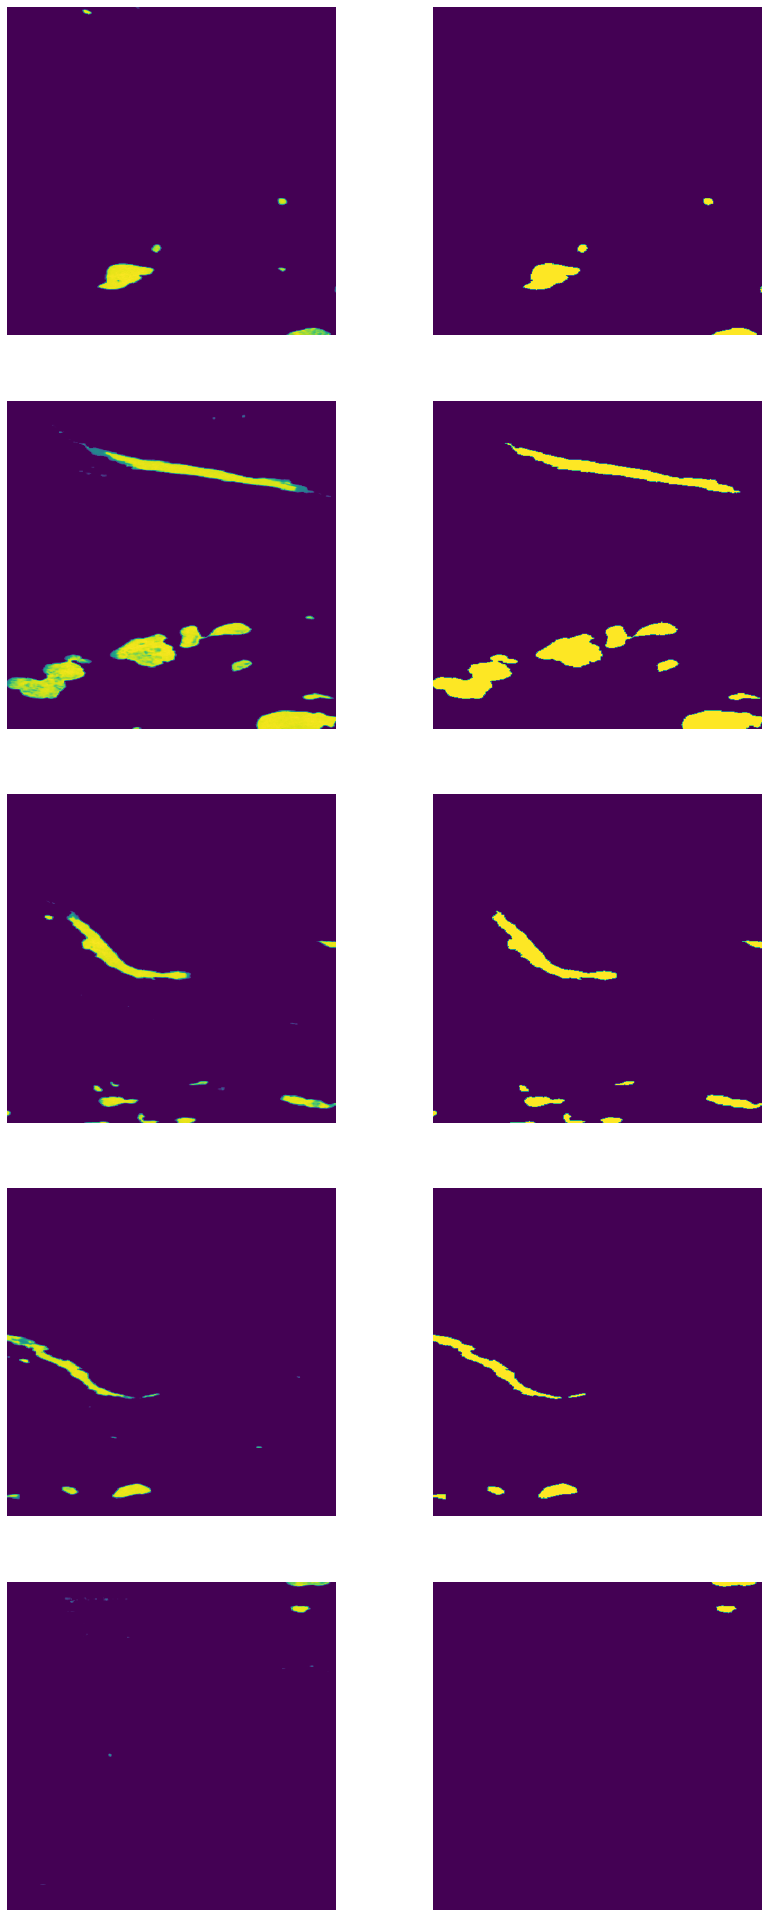

In [12]:
#Display the some of the test images
numberOfImagesToDisplay = 5

train_images, real_label = test_patches[0][:numberOfImagesToDisplay], test_patches[1][:numberOfImagesToDisplay]
display_images(np.concatenate((train_images,real_label), axis = -1))

In [28]:
#Evaluate model 

def evaluate_model(model_path, evaluation_report_filename):
    print(model_path, evaluation_report_filename)
    model = load_model(model_path, custom_objects={'tversky': tversky, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy , 'recall':recall,'precision':precision,'IoU':IoU}, compile=False)

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, accuracy,recall,precision,IoU])
    
    print('Evaluating model now!')
    ev = model.evaluate(x=test_patches[0], y=test_patches[1],  verbose=1, use_multiprocessing=False)
    report  = dict(zip(model.metrics_names, ev))
    report['model_path'] =  model_path   
    report['test_frame_dir']= base_dir   
    report['total_patch_count']= len(test_patches[0])  
    return report

report = evaluate_model(modelToEvaluate, evaluation_report_filename)

G:\U-Net\U-Net\saved_models\UNet\lakes_20230622-0246_AdaDelta_tversky_01_512.h5 G:\U-Net\U-Net\evaluationreport\evaluation_per_pixel20230622-0902_01.csv
Evaluating model now!
47/47 [==============================] - 36s 598ms/step - loss: 0.0384 - dice_coef: 0.9519 - dice_loss: 0.0481 - accuracy: 0.9947 - recall: 0.9389 - precision: 0.9679 - IoU: 0.9549


In [ ]:
# Show the model predictions! 

model = load_model(modelToEvaluate, custom_objects={'tversky': tversky, 'dice_coef': dice_coef, 'dice_loss':dice_loss, 'accuracy':accuracy ,'mIoU':mIoU, 'specificity': specificity, 'sensitivity':sensitivity}, compile=False)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=[dice_coef, dice_loss, accuracy,mIoU, specificity, sensitivity])

grwl_path = os.path.join(auxiliary_data_dir, 'GRWL') 
OSM_path =  os.path.join(auxiliary_data_dir, 'OSM_water') 
occurrence_eq0_path = os.path.join(auxiliary_data_dir, 'occurrence_eq0_sum.gdb')
outpatches = os.path.join(base_dir, 'predictions_patches')
if not os.path.exists(outpatches):
    os.makedirs(outpatches)

# load patch meta tempelate for further edition
with rasterio.open(os.path.join(auxiliary_data_dir, 'occurrence/occurrence_0E10E_0N10N.tif')) as raster_template:
    #print(raster_template.meta)
    meta_template = raster_template.meta 

predictions, predictions_masked = [], []
for i, tp in enumerate(test_patches[0]):
    tpx = np.expand_dims(tp, axis=0)
    modelpredtictions = model.predict(tpx, batch_size=BATCH_SIZE) # 1*512*512*1
    modelpredtictions = np.squeeze(modelpredtictions, axis = 3) # 1*512*512
#     print(modelpredtictions.shape)
    
    # save ndarray of pathces to tif
    patch_lonlat_ul = test_patches[2][i]
    patch_lon_left = patch_lonlat_ul[0]
    patch_lat_up = patch_lonlat_ul[1]
    patch_transform = affine.Affine(0.00025, 0.0, patch_lon_left, 0.0, -0.00025, patch_lat_up)
    patch_meta = meta_template.copy()
    patch_meta.update({
              "dtype": 'float32',
              "height": patch_size[0],
              "width": patch_size[1],
              "transform": patch_transform,
              "compress": 'lzw'}) #
#     print('patch_meta', patch_meta)
    with rasterio.open(outpatches+'/patches_'+str(i)+'.tif', 'w', **patch_meta) as prediction_patch_dataset:
        prediction_patch_dataset.write(modelpredtictions)
    
    # select all types of masks based on the pathces bbox
    bbox = rasterio.transform.array_bounds(patch_meta['height'], patch_meta['width'], patch_transform)
    grwl_dn255_patch = gps.read_file(grwl_path+'/GRWL_DN255.shp', bbox=bbox) # data from GRWL_mask_V01.01 product with DN = 255 (River) (see https://doi.org/10.5281/zenodo.1297434).
    grwl_dn126_patch = gps.read_file(grwl_path+'/GRWL_DN126.shp', bbox=bbox) # data from GRWL_mask_V01.01 product with DN = 126 (Tidal rivers/delta) (see https://doi.org/10.5281/zenodo.1297434).
    grwl_dn86_patch = gps.read_file(grwl_path+'/GRWL_DN86.shp', bbox=bbox) # data from GRWL_mask_V01.01 product with DN = 126 (Canal) (see https://doi.org/10.5281/zenodo.1297434).
    OSM_patch = gps.read_file(OSM_path+'/mergeocean.shp', bbox=bbox) # data from OSMWL with gridcode = 1 (Ocean) (see http://hydro.iis.u-tokyo.ac.jp/~yamadai/OSM_water/index.html).
    occurrence_eq0_patch = gps.read_file(occurrence_eq0_path, layer='occurrence_eq0', bbox=bbox) # data from GSWO with value = 0 (Land / Not water), available at https://global-surface-water.appspot.com.
    mask_patch = grwl_dn255_patch.append(grwl_dn126_patch).append(grwl_dn86_patch).append(OSM_patch).append(occurrence_eq0_patch)
    mask_patch_geojson = mask_patch.geometry.values 
    
    # perform river mask and ocean mask
    with rasterio.open(outpatches+'/patches_'+str(i)+'.tif', 'r') as prediction_patch_dataset:
        if len(mask_patch_geojson) > 0:
            modelpredtictions_masked, out_meta = rasterio.mask.mask(prediction_patch_dataset, mask_patch_geojson, all_touched=True, invert=True)
            print(f'Mask finished: {i+1} / {len(test_patches[0])}')
        else:
            modelpredtictions_masked = modelpredtictions.copy()
            print(f'No masks detected, output original image instead: {i+1} / {len(test_patches[0])}')
    with rasterio.open(outpatches+'/patches_masked_'+str(i)+'.tif', "w", **patch_meta) as prediction_masked_patch_dataset:
        prediction_masked_patch_dataset.write(modelpredtictions_masked)

    predictions.append(np.transpose(modelpredtictions, axes=(1,2,0)))
    predictions_masked.append(np.transpose(modelpredtictions_masked, axes=(1,2,0)))

In [ ]:
# Transform Contours from image to world coordinates  
def transform_contours_to_xy(contours, transform):
    tp = []
    for cnt in contours:
        pl = cnt[:, 0, :]
        cols, rows = zip(*pl)
        x,y = rasterio.transform.xy(transform, rows, cols)
        if not isinstance(x, list):
            x = [x]
            y = [y]
        tl = [list(i) for i in zip(x, y)]
        tp.append(tl)
    return (tp)

def mask_to_polygons(mask, transform,j,th = 0.5):
    # first, find contours with cv2: it's much faster than shapely and returns hierarchy 
    mask[mask < th] = 0 
    mask[mask >= th] = 1
    mask = ((mask) * 255).astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    
    #Convert contours from image coordinate to xy coordinate (world coordinates) 
    contours = transform_contours_to_xy(contours, transform)
    
    if contours:
        print(f'Finish contours/polygons detected in: {j+1} / {len(test_patches[0])}')
    else: #TODO: Raise an error maybe
        print(f'No detected in: {j+1} / {len(test_patches[0])}')
        return [Polygon()]
    
    # now messy stuff to associate parent and child contours 
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
            '''for (key, value) in data:   result[key].append(value)'''
            
    # create actual polygons filtering by area/hole (removes artifacts)  
    all_polygons = []
#     min_area=100 #gt 0.03km2
    for idx, cnt in enumerate(contours):
        if idx not in child_contours: #and cv2.contourArea(cnt) >= min_area: #Do we need to check for min_area??
            try:
                poly = Polygon(
                    shell=cnt,
                    holes=[c for c in cnt_children.get(idx, []) ])
                           #if cv2.contourArea(c) >= min_area]) #Do we need to check for min_area??
#                     holes=[c for c in cnt_children.get(idx, []) if cv2.contourArea(c) >= min_area])
                all_polygons.append(poly)
            except Exception as e: 
#                 print(e)
                pass   
    #print(len(all_polygons))
    return(all_polygons)
    

In [ ]:
import pyproj    
import shapely
import shapely.ops as ops

def transform_to_meter_coordinate_system(geom):
    # TODO: Remove the hard coded values
    project = pyproj.Transformer.from_proj(
        pyproj.Proj(init='epsg:4326'), # source coordinate system  
        pyproj.Proj(init='epsg:8857')) # destination coordinate system   
    gt = ops.transform(project.transform, geom)  # apply projection
    return gt

def ha_area(ha_polygons):
    ts = 0
    ha_polygons_meter = [transform_to_meter_coordinate_system(p) for p in ha_polygons]
    for p in ha_polygons_meter:
        if p.area > 0.03*(10**6):#minarea=0.015*10^6
            ts += p.area
    return ts

def ha_area_polygons(ha_polygons):
    polygons_number=0
    ha_polygons_meter = [transform_to_meter_coordinate_system(p) for p in ha_polygons]
    for p in ha_polygons_meter:
        if p.area > 0.03*(10**6):#minarea=0.015*10^6
            polygons_number =polygons_number+1
#     area_polygonsnumber=np.concatenate([ts,polygons_number],axis=1)
    return polygons_number

In [ ]:
# TODO: Remove the need for the a tiff file for transformation 
ha_prediction_polygons = []
ha_label_polygons = []
    
ha_prediction_canopy_area = []
ha_label_canopy_area = []

for em, pred in enumerate(predictions_masked):
    with rasterio.open(outpatches+'/patches_masked_'+str(em)+'.tif', "r") as raster_image:
#         print(raster_image.meta)
        transform = raster_image.meta['transform']
#         print(transform)
    ap = mask_to_polygons(pred, transform,em)
#     print(ap)
#     createShapefileObject(ap, raster_image.meta, outpatches,em)
    ha_prediction_polygons.append(ap)
#     ha_prediction_canopy_area.append(ha_area_from_mask(pred))
    
for i, lb in enumerate(test_patches[1][...,[0]]):
    with rasterio.open(outpatches+'/patches_masked_'+str(i)+'.tif', "r") as raster_image:
        #print(raster_image.meta)
        transform = raster_image.meta['transform']
            
    ap = mask_to_polygons(lb, transform,i)#
    ha_label_polygons.append(ap)
# ha_label_canopy_area.append(ha_area_from_mask(lb))

In [ ]:
ha_prediction_polygons_count = [len(hp) for hp in ha_prediction_polygons] 
ha_label_polygons_count = [len(hp) for hp in ha_label_polygons] 

# Alternate method to calcualte canopy area as a sum of area of trees  
print('To calculate the area we convert the polygons to a coordinate system where unit is meters. This process is time consuming.')

ha_prediction_canopy_area= list(map(ha_area, ha_prediction_polygons))
ha_prediction_polygons_number=list(map(ha_area_polygons, ha_prediction_polygons))

ha_label_canopy_area= list(map(ha_area, ha_label_polygons))
ha_label_polygons_number=list(map(ha_area_polygons, ha_label_polygons))

In [ ]:
from scipy.stats import pearsonr
print(len(ha_prediction_polygons_number))
ha_count_correlation = pearsonr(ha_prediction_polygons_number, ha_label_polygons_number)
ha_area_correlation = pearsonr(ha_prediction_canopy_area, ha_label_canopy_area)

print('Count correlation:' + str(ha_count_correlation))
print('Area correlation:' + str(ha_area_correlation))


In [32]:
# Generate the final report
# report['count_correlation'] =  ha_count_correlation[0]
# report['count_correlation_tvalue'] =  ha_count_correlation[1]
# report['area_correlation'] = ha_area_correlation[0]
# report['area_correlation_tvalue'] =  ha_area_correlation[1]

print(report)

tdf = pd.DataFrame(report, index=[0])  
print(tdf.columns)
col_beginning = ['model_path','test_frame_dir', 'total_patch_count']

col_rest = [x for x in tdf.columns.tolist() if x not in col_beginning]
cols = col_beginning + col_rest
tdf = tdf[cols]
tdf.to_csv(evaluation_report_filename)

{'loss': 0.03835441544651985, 'dice_coef': 0.9519357085227966, 'dice_loss': 0.04805641993880272, 'accuracy': 0.9946967363357544, 'recall': 0.9388536214828491, 'precision': 0.9679042100906372, 'IoU': 0.9549177289009094, 'model_path': 'G:\\U-Net\\U-Net\\saved_models\\UNet\\lakes_20230622-0246_AdaDelta_tversky_01_512.h5', 'test_frame_dir': 'G:\\U-Net\\U-Net', 'total_patch_count': 1474}
Index(['loss', 'dice_coef', 'dice_loss', 'accuracy', 'recall', 'precision',
       'IoU', 'model_path', 'test_frame_dir', 'total_patch_count'],
      dtype='object')


In [ ]:
ha_label_canopy_area_km2 = [x/1e6 for x in ha_label_canopy_area]
ha_prediction_canopy_area_km2 = [x/1e6 for x in ha_prediction_canopy_area]
# print(ha_label_canopy_area_km2)

In [ ]:
from scipy import optimize
from scipy import stats
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import MultipleLocator


fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=150) 

ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k')


plt.scatter(ha_label_polygons_number,ha_prediction_polygons_number,s=20,c='b',alpha=.4, marker='o')

plt.tick_params(labelsize=10)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]


res = stats.linregress(ha_label_polygons_number, ha_prediction_polygons_number) 
plt.plot(ha_label_polygons_number, res.intercept + res.slope*np.array(ha_label_polygons_number), 'r')
RMSE = mean_squared_error(ha_label_polygons_number, ha_prediction_polygons_number, squared=False)#RMSE

ax.text(5,75,f"Slope: {res.slope:.3f}\nR-squared: {res.rvalue**2:.3f}\nRMSE: {RMSE:.3f}\nPatch:{len(ha_label_canopy_area_km2)}",fontproperties='Times New Roman')
plt.xlabel('Label density',fontproperties='Times New Roman')    
plt.ylabel('Prediction density',fontproperties='Times New Roman')  
plt.show()

In [ ]:
patch_polygonsnumber = pd.DataFrame({
    'ha_label_polygons_number': ha_label_polygons_number,
    'ha_prediction_polygons_number': ha_prediction_polygons_number,
})
patch_polygonsnumber.to_csv(os.path.join(evaluation_report_path, 'a_patch_polygonsnumber.csv')) 

In [ ]:
from scipy import optimize
from scipy import stats
from sklearn.metrics import mean_squared_error
%matplotlib inline
from matplotlib.pyplot import MultipleLocator


fig, ax = plt.subplots(1,1,figsize=(5,5),dpi=150) 
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k')

plt.scatter(ha_label_canopy_area_km2,ha_prediction_canopy_area_km2,s=20,c='b',alpha=.4, marker='o')

plt.tick_params(labelsize=10)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]


res = stats.linregress(ha_label_canopy_area_km2, ha_prediction_canopy_area_km2) 

plt.plot(ha_label_canopy_area_km2, res.intercept + res.slope*np.array(ha_label_canopy_area_km2), 'r')
RMSE = mean_squared_error(ha_label_canopy_area_km2, ha_prediction_canopy_area_km2, squared=False)#RMSE

ax.text(5,60,f"Slope: {res.slope:.3f}\nR-squared: {res.rvalue**2:.3f}\nRMSE: {RMSE:.3f}\nPatch:{len(ha_label_canopy_area_km2)}",fontproperties='Times New Roman')
plt.xlabel('Label area (${km^2}$)',fontproperties='Times New Roman')    
plt.ylabel('Prediction area (${km^2}$)',fontproperties='Times New Roman')  
plt.show()

In [ ]:
patch_area_df = pd.DataFrame({
    'ha_label_canopy_area_km2': ha_label_canopy_area_km2,
    'ha_prediction_canopy_area_km2': ha_prediction_canopy_area_km2,
})
patch_area_df.to_csv(os.path.join(evaluation_report_path, 'a_patch_area_km2.csv')) 